In [25]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy import stats
import os

# Set plot style for better visuals
sns.set(style='whitegrid')
# Load the CSV file into a DataFrame
data = pd.read_csv('./instagram_data.csv')

# Show the first few rows of the dataset
data.head()
data.shape


(3785, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   likes                3785 non-null   int64 
 1   no_of_comments       3785 non-null   int64 
 2   t                    3785 non-null   int64 
 3   follower_count_at_t  3785 non-null   int64 
 4   image_path           3785 non-null   object
dtypes: int64(4), object(1)
memory usage: 148.0+ KB
likes                  0
no_of_comments         0
t                      0
follower_count_at_t    0
image_path             0
dtype: int64


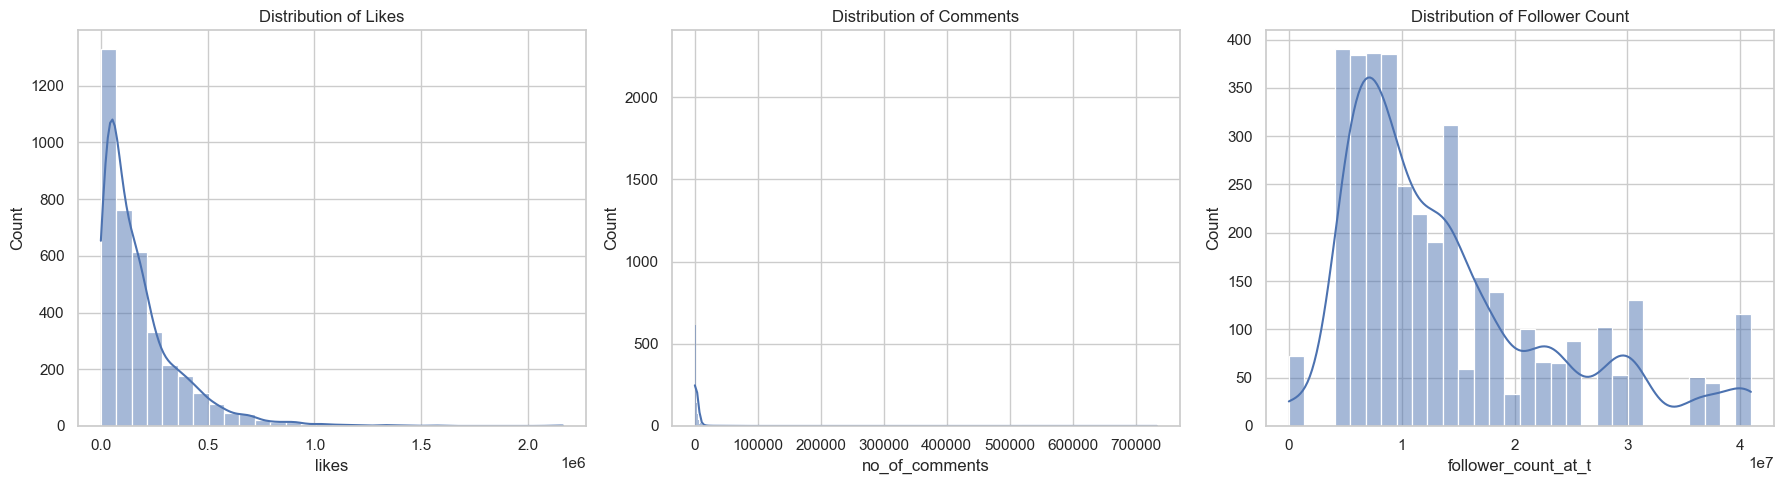

In [26]:
# Get basic information about the data (types, non-null counts, etc.)
data.info()

# Check for missing values
print(data.isnull().sum())

# Show descriptive statistics for numeric columns
data.describe()

# Visualize the distribution of likes, comments, and follower count
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot distribution of 'likes'
sns.histplot(data['likes'], ax=axes[0], bins=30, kde=True)
axes[0].set_title('Distribution of Likes')

# Plot distribution of 'no_of_comments'
sns.histplot(data['no_of_comments'], ax=axes[1], bins=1000, kde=True)
axes[1].set_title('Distribution of Comments')

# Plot distribution of 'follower_count_at_t'
sns.histplot(data['follower_count_at_t'], ax=axes[2], bins=30, kde=True)
axes[2].set_title('Distribution of Follower Count')

plt.tight_layout()
plt.show()


In [27]:
# Check skewness
print(f"Skewness of no_of_comments: {data['no_of_comments'].skew()}")
print(f"Skewness of follower_count_at_t: {data['follower_count_at_t'].skew()}")
print(f"Skewness of likes: {data['likes'].skew()}")

Skewness of no_of_comments: 25.69484042363528
Skewness of follower_count_at_t: 1.1649474985114856
Skewness of likes: 2.5605037498979613


This shows that log transformations would be helpful to apply to the data - the high skew in no_of_comments suggests outliers

In [28]:
print(data[data.no_of_comments == 0].shape, data[data.no_of_comments > 10000].shape)

# Comments over 10000 are few and far in between, while comments at 0 could be due to post locking, which we do not want to predict for
data = data[data.no_of_comments < 10000]
data = data[data.no_of_comments > 0]

(62, 5) (105, 5)


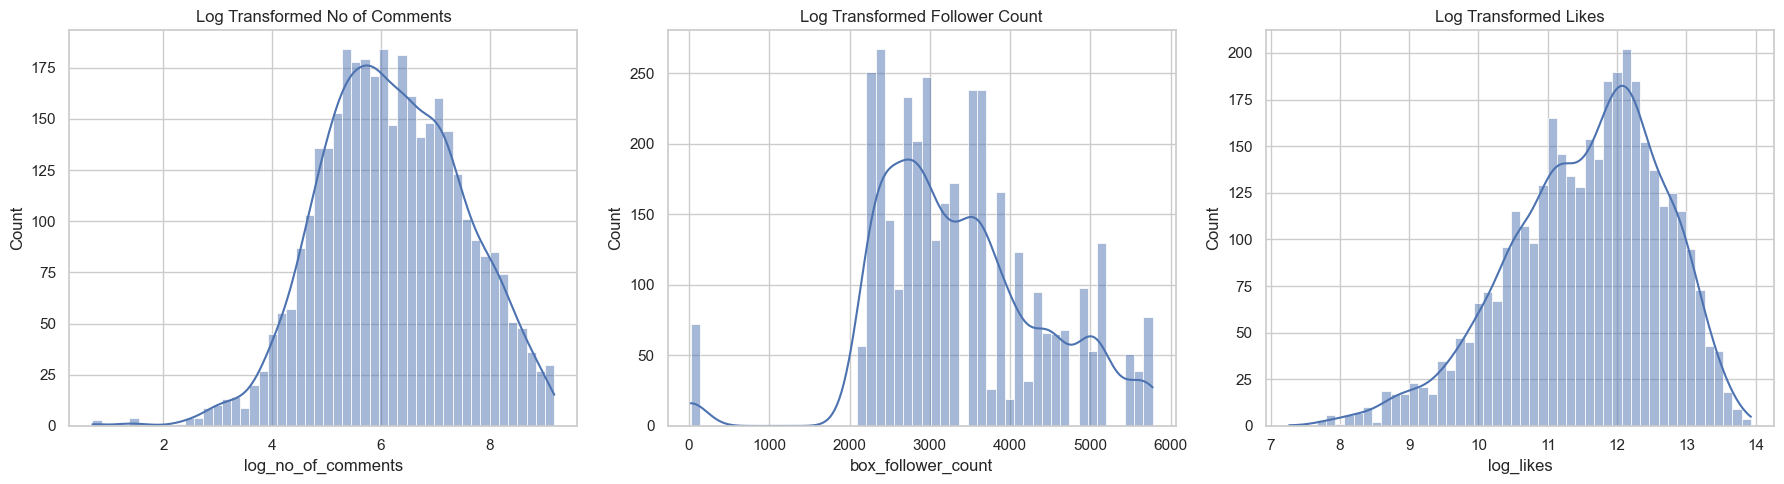

In [29]:
# Drop original columns if you no longer need them
if 'no_of_comments' in data.columns:
    
    # Apply log transformation to reduce skewness
    data['log_no_of_comments'] = np.log1p(data['no_of_comments'])  # log1p to avoid issues with log(0)
    data['box_follower_count'], lambda_ = stats.boxcox(data['follower_count_at_t'] + 1)
    data['log_likes'] = np.log1p(data['likes'])
    data.drop(columns=['no_of_comments', 'follower_count_at_t', 'likes'], inplace=True)

# Plot transformed features
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data['log_no_of_comments'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Log Transformed No of Comments')

sns.histplot(data['box_follower_count'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log Transformed Follower Count')

sns.histplot(data['log_likes'], bins=50, kde=True, ax=ax[2])
ax[2].set_title('Log Transformed Likes')

plt.tight_layout()
plt.show()

In [30]:
# Check skewness
print(f"Skewness of no_of_comments: {data['log_no_of_comments'].skew()}")
print(f"Skewness of follower_count_at_t: {data['box_follower_count'].skew()}")
print(f"Skewness of likes: {data['log_likes'].skew()}")

Skewness of no_of_comments: -0.10212132606600181
Skewness of follower_count_at_t: 0.022131539481896178
Skewness of likes: -0.5671110395927492


Originally, I ran log transformations on all of the above, but still found a negative skew on follower_count - so I opted to transform using boxcox. The skews are a lot less aggressive, showing these transformations have more or less worked

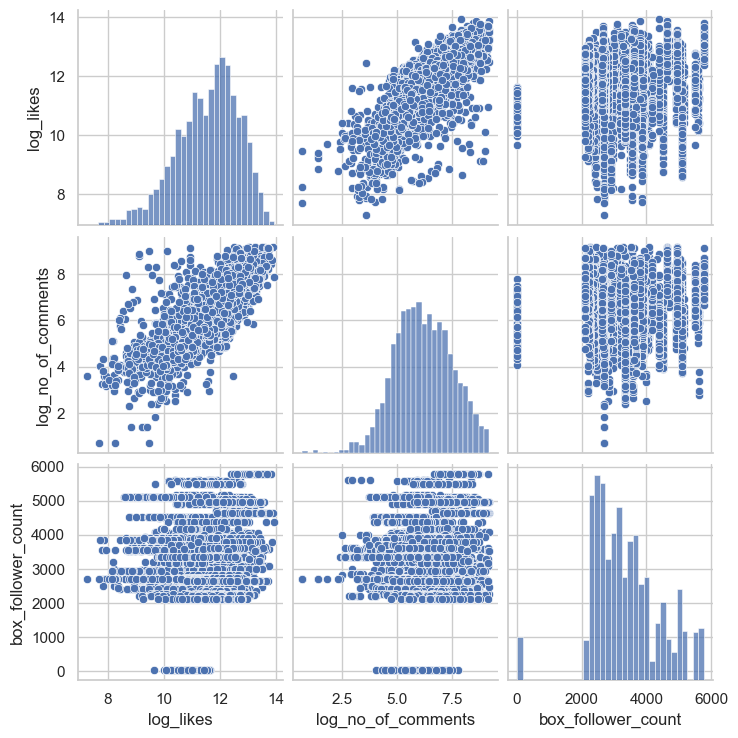

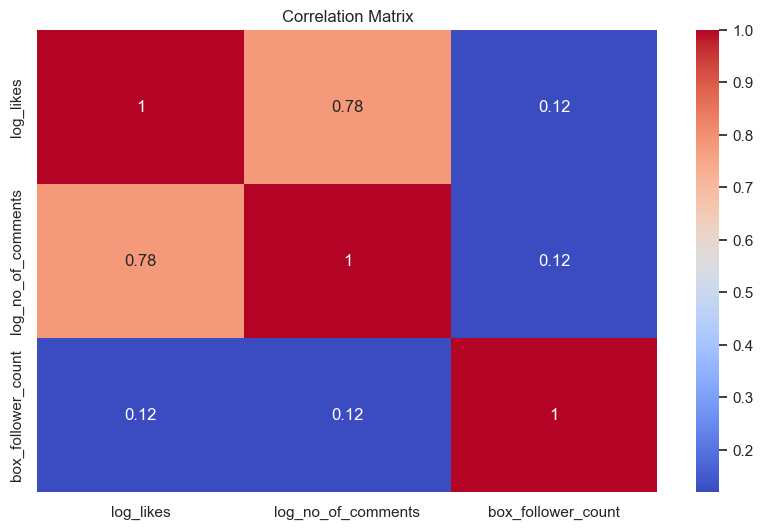

In [32]:
# Plot relationships between variables using pairplot
sns.pairplot(data[['log_likes', 'log_no_of_comments', 'box_follower_count']])
plt.show()

# Check correlations between numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(data[['log_likes', 'log_no_of_comments', 'box_follower_count']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [45]:
#Add new features
data['post_time'] = pd.to_datetime(data['t'], unit='s')
data['hour_of_day'] = data['post_time'].dt.hour  # Extract hour of the day (0-23)
data['day_of_week'] = data['post_time'].dt.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
data['month'] = data['post_time'].dt.month  # Extract the month (1-12)
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # Binary weekend feature

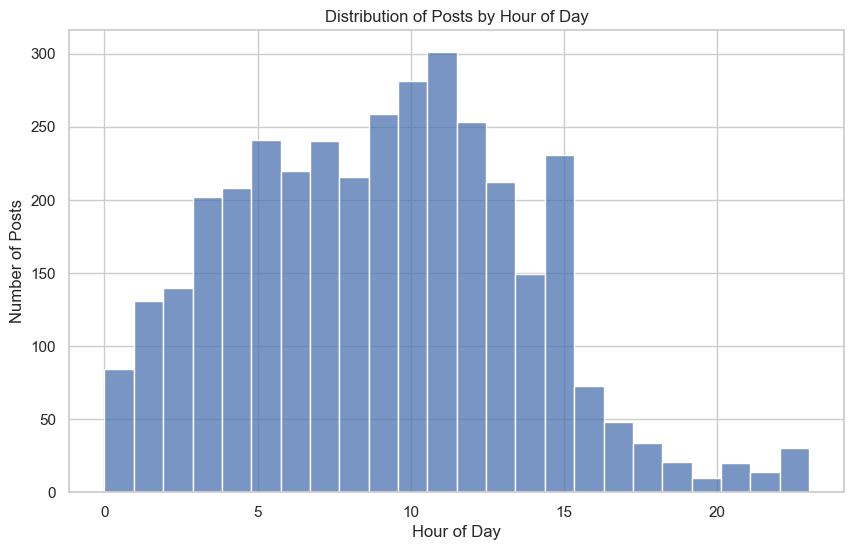

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the hour of the day
plt.figure(figsize=(10,6))
sns.histplot(data['hour_of_day'], bins=24, kde=False)
plt.title('Distribution of Posts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.show()


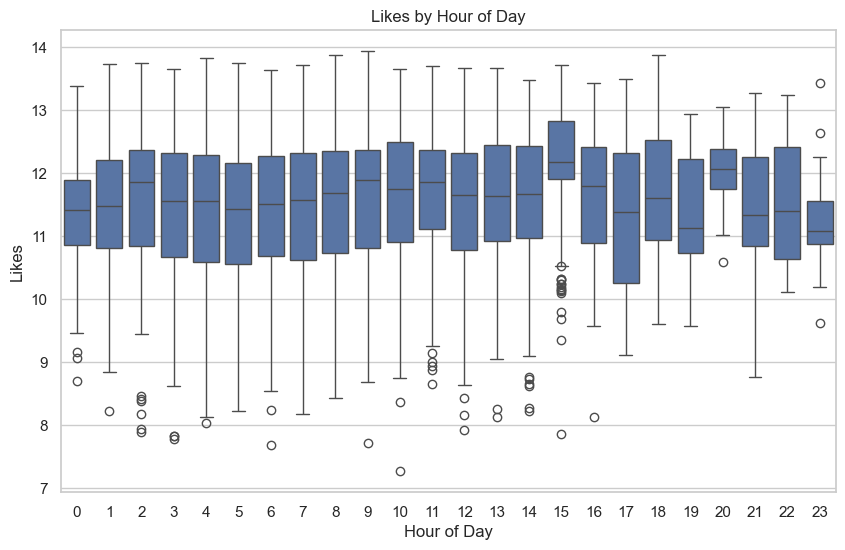

In [37]:
plt.figure(figsize=(10,6))
sns.boxplot(x='hour_of_day', y='log_likes', data=data)
plt.title('Likes by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Likes')
plt.show()

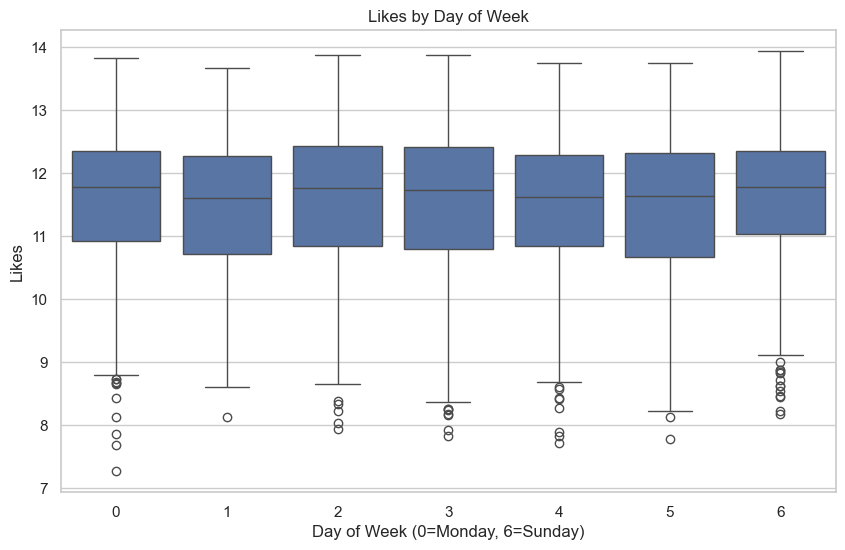

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(x='day_of_week', y='log_likes', data=data)
plt.title('Likes by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Likes')
plt.show()


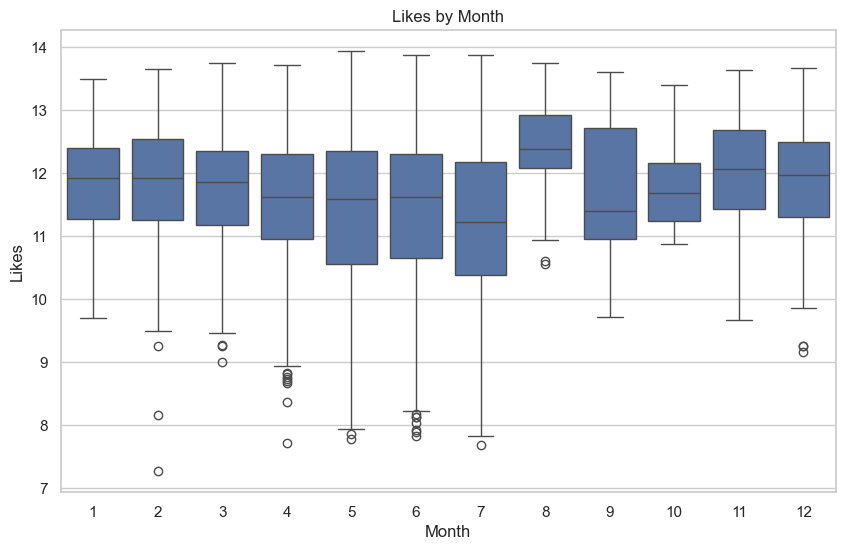

In [40]:
plt.figure(figsize=(10,6))
sns.boxplot(x='month', y='log_likes', data=data)
plt.title('Likes by Month')
plt.xlabel('Month')
plt.ylabel('Likes')
plt.show()


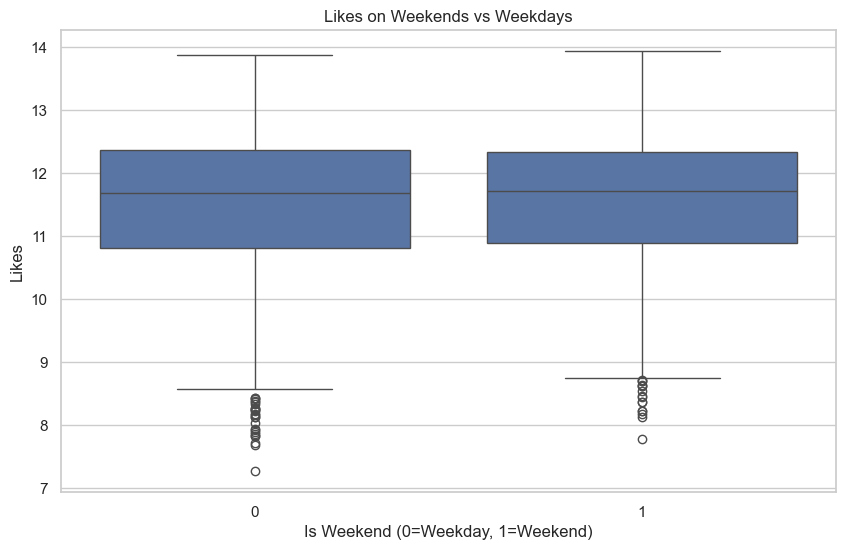

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_weekend', y='log_likes', data=data)
plt.title('Likes on Weekends vs Weekdays')
plt.xlabel('Is Weekend (0=Weekday, 1=Weekend)')
plt.ylabel('Likes')
plt.show()


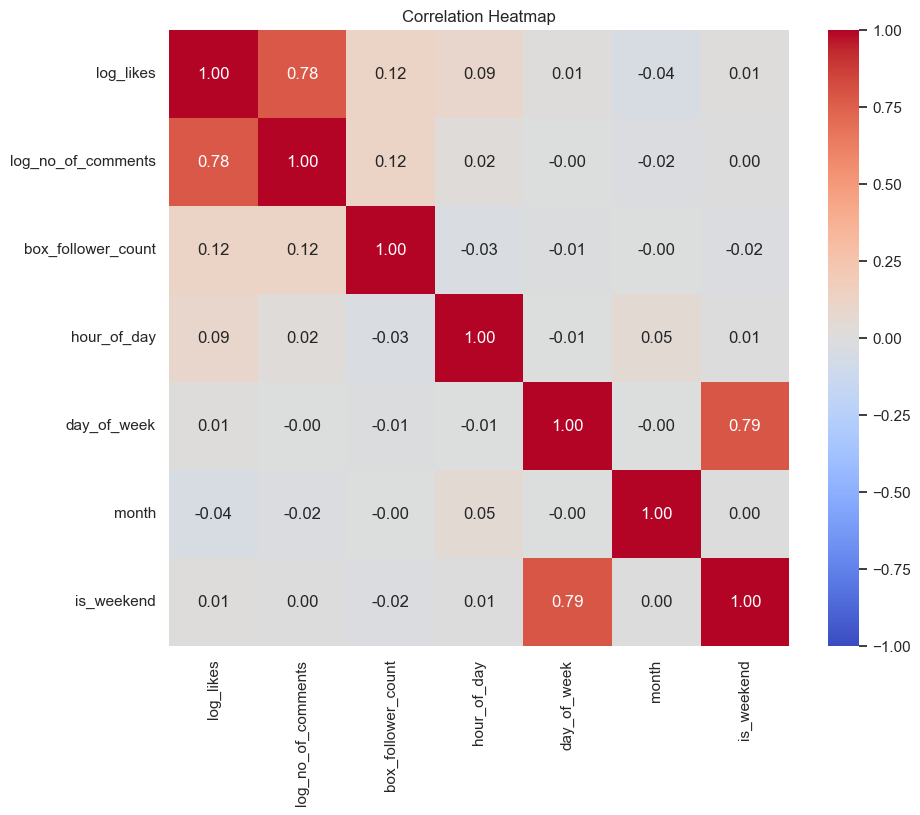

In [43]:
# Calculate the correlation matrix
corr = data[['log_likes', 'log_no_of_comments', 'box_follower_count', 'hour_of_day', 'day_of_week', 'month', 'is_weekend']].corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Create cyclical encodings as this time data is cyclical
data['hour_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)  # Extract hour of the day (0-23)
data['hour_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)  # Extract hour of the day (0-23)

data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)  # Extract day of the week (0=Monday, 6=Sunday)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['month_sin'] = np.sin(2 * np.pi * data['post_time'].dt.month / 12)  # Extract the month (1-12)
data['month_cos'] = np.cos(2 * np.pi * data['post_time'].dt.month / 12)

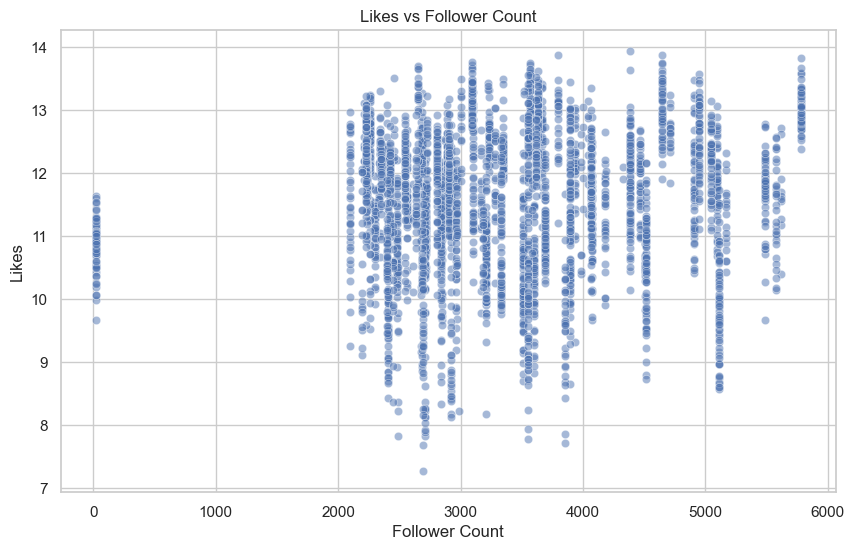

In [44]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='box_follower_count', y='log_likes', data=data, alpha=0.5)
plt.title('Likes vs Follower Count')
plt.xlabel('Follower Count')
plt.ylabel('Likes')
plt.show()


Overall, looks like no_of_comments and follower_count_at_t have the most to do with the number of likes on a given post. To avoid collinearity issues, I won't be including is_weekend in metadata analysis.